# Imports

In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
import glob
import errno

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline



# Read all files from all folders

In [2]:

path = '/home/mscuser/Desktop/nlp/nipstxt/nips*/*.txt'
files = glob.glob(path)
data=[]
data2=[]
for name in files:
    try:
        with open(name, encoding = "ISO-8859-1") as f:
            data.append(str(f.readlines()))
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise
print(len(data))


1740


# Preprocessing

In [3]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove possible distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [5]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


The LDA topic model algorithm requires a document word matrix as the main input.
I have configured the CountVectorizer to consider words that has occurred at least 10 times (min_df), remove built-in english stopwords, convert all words to lowercase, and a word can contain numbers and alphabets of at least length 3 in order to be qualified as a word.

Since most cells contain zeros, the result will be in the form of a sparse matrix to save memory.

If you want to materialize it in a 2D array format, call the todense() method of the sparse matrix like its done in the next step.

In [6]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [7]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  6.06407811506758 %


In [17]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [18]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -16665471.901540887
Perplexity:  1280.7301094295913
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


The most important tuning parameter for LDA models is n_components (number of topics). In addition, I am going to search learning_decay (which controls the learning rate) as well.

Besides these, other possible search params could be learning_offset (downweigh early iterations. Should be > 1) and max_iter. These could be worth experimenting if you have enough computing resources.

In [19]:
%%time
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

/home/mscuser/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/mscuser/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/mscuser/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/mscuser/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'bat

/home/mscuser/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/mscuser/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/mscuser/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/mscuser/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'bat

CPU times: user 21min 34s, sys: 12min 22s, total: 33min 57s
Wall time: 21min 13s


In [20]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'n_components': 10, 'learning_decay': 0.5}
Best Log Likelihood Score:  -5752875.995775425
Model Perplexity:  1325.8349901376248


based on the log-likelihood scores against num_topics, we can see that number of topic 10 has better scores.
And learning_decay of 0.5 outperforms the other two.

/home/mscuser/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/mscuser/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/mscuser/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


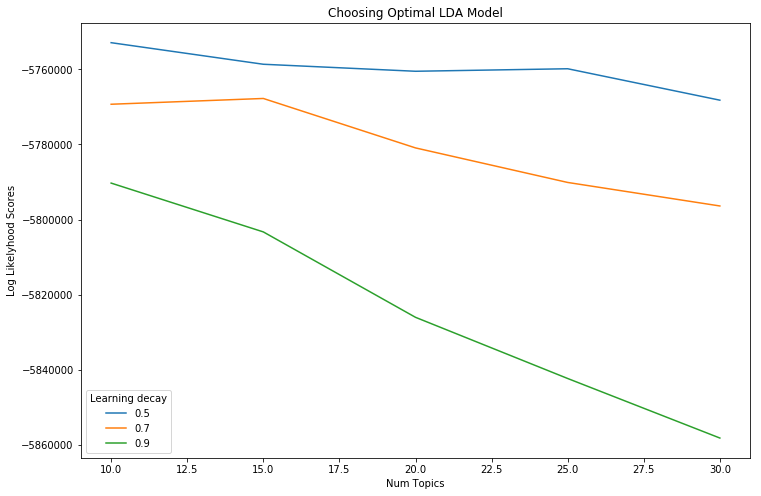

In [21]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In the table below, I’ve greened out all major topics in a document and assigned the most dominant topic in its own column.

In [28]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

here you can see the most representative document per topic with its probability as well as the topic distribution

In [27]:
count=0
for column in df_document_topic:
    if count<10:
        print("The most representative document for "+column+" is: "+df_document_topic[column].idxmax()+" with a probability of: "+str(df_document_topic[column].max()))
    count=count+1

The most representative document for Topic0 is: Doc1250 with a probability of: 0.87
The most representative document for Topic1 is: Doc1560 with a probability of: 0.93
The most representative document for Topic2 is: Doc494 with a probability of: 1.0
The most representative document for Topic3 is: Doc284 with a probability of: 0.86
The most representative document for Topic4 is: Doc532 with a probability of: 0.93
The most representative document for Topic5 is: Doc752 with a probability of: 0.98
The most representative document for Topic6 is: Doc1557 with a probability of: 0.75
The most representative document for Topic7 is: Doc1424 with a probability of: 0.93
The most representative document for Topic8 is: Doc102 with a probability of: 1.0
The most representative document for Topic9 is: Doc824 with a probability of: 0.92


In [29]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

Topic Num  Num Documents
0          8            274
1          1            243
2          7            214
3          3            196
4          0            188
5          2            163
6          9            155
7          5            150
8          4            124
9          6             33

The pyLDAvis offers the best visualization to view the topics-keywords distribution.
A good topic model will have non-overlapping, fairly big sized blobs for each topic. This seems to be the case here. So, we are good.

In [30]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/home/mscuser/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
8      13.825002        1       1  -51.265133  -31.394314
7      13.731416        1       2  -44.992584 -147.107574
3      11.782016        1       3   85.688484  133.371384
1      11.423643        1       4  -46.063160  191.125900
0      10.441582        1       5   54.361820    5.787583
5      10.217087        1       6   82.711006 -109.199631
9       9.136962        1       7  -30.554295   78.669914
2       8.976012        1       8 -150.110901   80.953957
4       7.519906        1       9 -164.919052  -52.334919
6       2.946373        1      10  167.526779   17.577360, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
4573  Default  31435.000000       network  31435.000000  30.0000  30.0000
3250  Default   6786.000000         image   6786.000000  29.0000  29.0000
935   Default   6766.000000          cell   6766.000000  28.0000  28.0000
6565  Default  10240.000000         state  10240.000000  27.0000  27.0000
4598  Default   8466.000000        neuron   8466.000000  26.0000  26.0000
3856  Default  14297.000000         learn  14297.000000  25.0000  25.0000
4361  Default  23543.000000         model  23543.000000  24.0000  24.0000
7127  Default  10316.000000      training  10316.000000  23.0000  23.0000
7314  Default  11803.000000          unit  11803.000000  22.0000  22.0000
4112  Default   3496.000000           map   3496.000000  21.0000  21.0000
2220  Default  10009.000000         error  10009.000000  20.0000  20.0000
2765  Default  17136.000000      function  17136.000000  19.0000  19.0000
3842  Default   6606.000000         layer   6606.000000  18.0000  18.0000
196   Default  12476.000000     algorithm  12476.000000  17.0000  17.0000
7584  Default  11126.000000        weight  11126.000000  16.0000  16.0000
4715  Default   3274.000000        object   3274.000000  15.0000  15.0000
3860  Default   8872.000000      learning   8872.000000  14.0000  14.0000
2450  Default   6171.000000       feature   6171.000000  13.0000  13.0000
5662  Default   4475.000000   recognition   4475.000000  12.0000  12.0000
5000  Default   8442.000000       pattern   8442.000000  11.0000  11.0000
5729  Default   2971.000000        region   2971.000000  10.0000  10.0000
7036  Default  13291.000000          time  13291.000000   9.0000   9.0000
1392  Default   4880.000000       control   4880.000000   8.0000   8.0000
1602  Default  11031.000000         datum  11031.000000   7.0000   7.0000
6501  Default   2783.000000        speech   2783.000000   6.0000   6.0000
3432  Default  17224.000000         input  17224.000000   5.0000   5.0000
4236  Default   3537.000000        memory   3537.000000   4.0000   4.0000
1317  Default   3683.000000    connection   3683.000000   3.0000   3.0000
7649  Default   2819.000000          word   2819.000000   2.0000   2.0000
6610  Default   2732.000000      stimulus   2732.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
5729  Topic10   1273.759791        region   2971.736228   2.6774  -3.9867
1755  Topic10    469.753661   development    871.062426   2.9071  -4.9842
4840  Topic10    314.524530      organize    530.964084   3.0010  -5.3854
6351  Topic10    309.930527          site    523.361928   3.0007  -5.4001
1684  Topic10    220.630210     dendritic    364.694156   3.0220  -5.7399
4549  Topic10    260.526133  neighborhood    466.425863   2.9422  -5.5737
5652  Topic10    495.220499     receptive   1337.939777   2.5307  -4.9314
147   Topic10    199.424039      afferent    355.549471   2.9464  -5.8410
86    Topic10    687.891258      activity   2985.278143   2.0568  -4.6028
935   Topic10   1099.624507          cell   6766.720899   1.7075  -4.1337
1472  Topic10    411.453759      cortical   1258.174090   2.4069  -5.1167
3842 